# EXPLORATION 14 : 어제 오른 내 주식, 과연 내일은?

## 준비한 데이터

### 각각 10년치
- 005930.KS.csv (삼성전자 데이터셋)
- 035420.KS.csv (네이버 데이터셋)
- 035720.KS.csv (카카오 데이터셋)
- AAPL.csv (애플 데이터셋)
- GE.csv (제너럴 일렉트릭 데이터셋)
- BTC-USD.csv (비트코인 데이터셋)

## 1. 시계열 데이터 준비

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib.pylab import rcParams

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/datas/005930.KS.csv' # 삼성전자
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2011-09-02    15380.0
2011-09-05    14620.0
2011-09-06    14540.0
2011-09-07    15460.0
2011-09-08    15960.0
Name: Close, dtype: float64

ts = df['Close']에서 Close를 사용한 이유는 여러 컬럼  
시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume) 중에  
종가(Close)가 하루의 장이 마감한 최종 가격이기 때문이다.

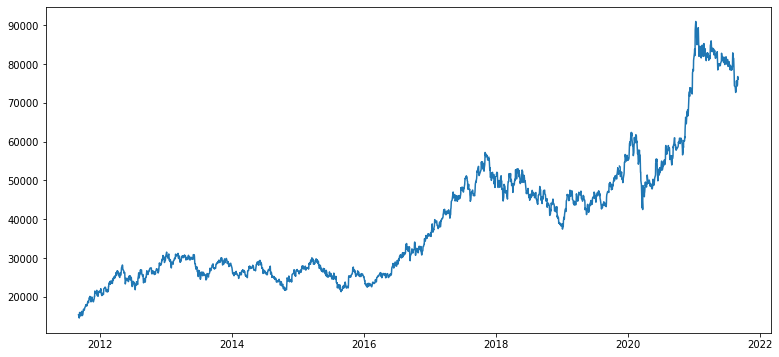

In [2]:
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정
plt.plot(ts) # 시계열(time series) 데이터를 차트로 시각화

꾸준히 우상향중인 삼성전자를 볼 수 있다.

## 2. 각종 전처리 수행

In [3]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

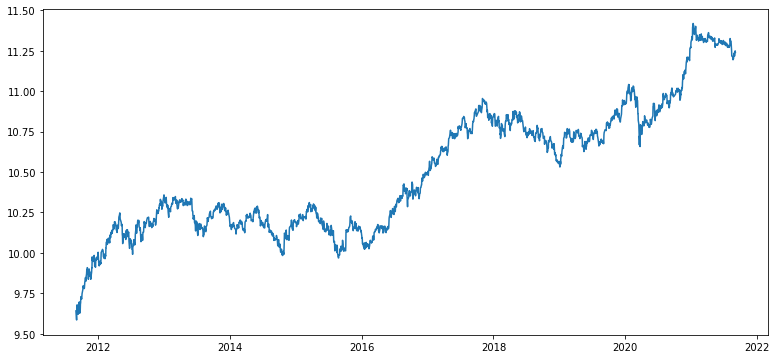

In [4]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

## 3. 시계열 안정성 분석

In [5]:
# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화하는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

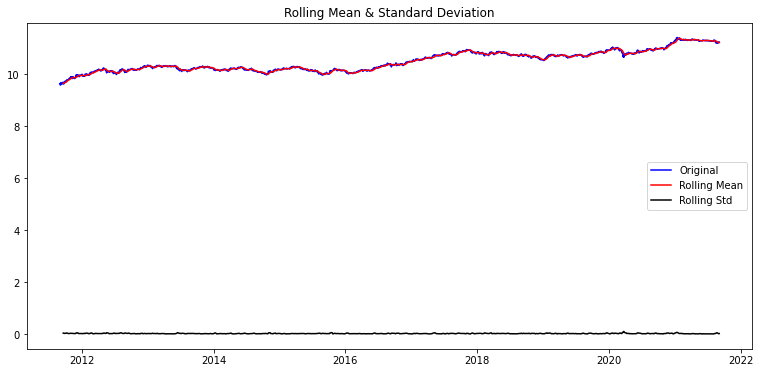

In [6]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [7]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [8]:
# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -1.200903
p-value                           0.673207
#Lags Used                        4.000000
Number of Observations Used    2459.000000
Critical Value (1%)              -3.433012
Critical Value (5%)              -2.862716
Critical Value (10%)             -2.567396
dtype: float64


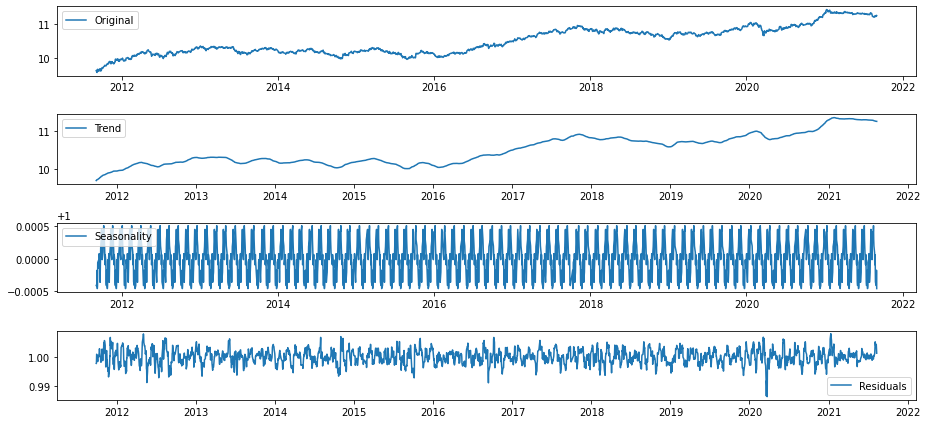

In [9]:
# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (13,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

statsmodels 라이브러리 안에는 seasonal_decompose 메소드를 통해  
시계열 안에 존재하는 trend, seasonality를 직접 분리해 낼 수 있는 기능이 존재하고  
안정적인 시계열을 분리해 낼 수 있게 도와준다.

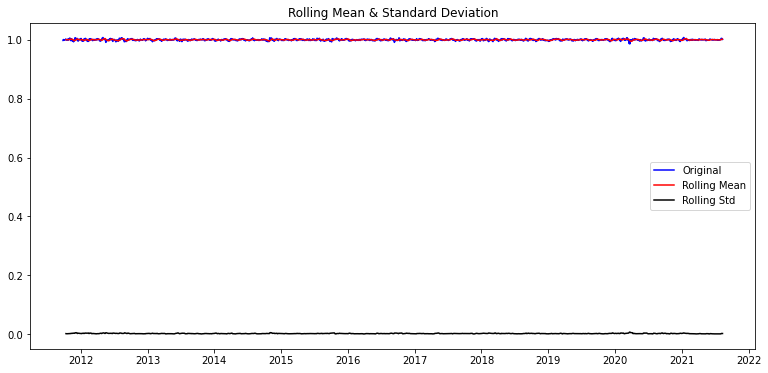

In [10]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [11]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.298411e+01
p-value                        2.902385e-24
#Lags Used                     2.600000e+01
Number of Observations Used    2.407000e+03
Critical Value (1%)           -3.433070e+00
Critical Value (5%)           -2.862742e+00
Critical Value (10%)          -2.567410e+00
dtype: float64


Original 시계열에서 Trend와 Seasonality를 제거하고 난 나머지를 Residual이라고 한다.  
여기서 Decomposing을 통해 얻어진 Residual은 압도적으로 낮은 p-value를 보여준다.  
이 정도면 예측 가능한 수준의 안정적인 시계열이라고 할 수 있을 것 같다.

## 4. 학습, 테스트 데이터셋 생성

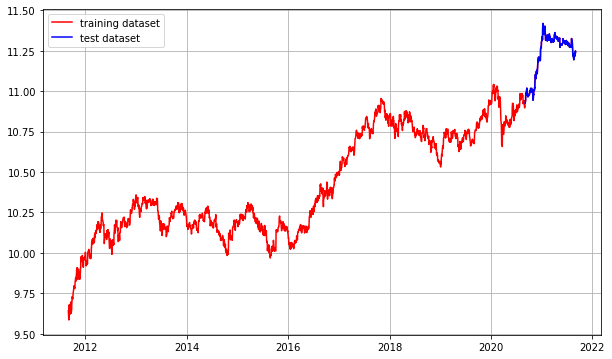

In [12]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## 5. 적정 ARIMA 모수 찾기

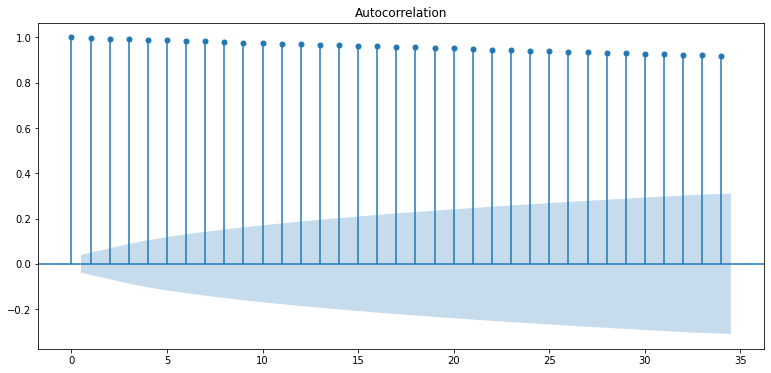

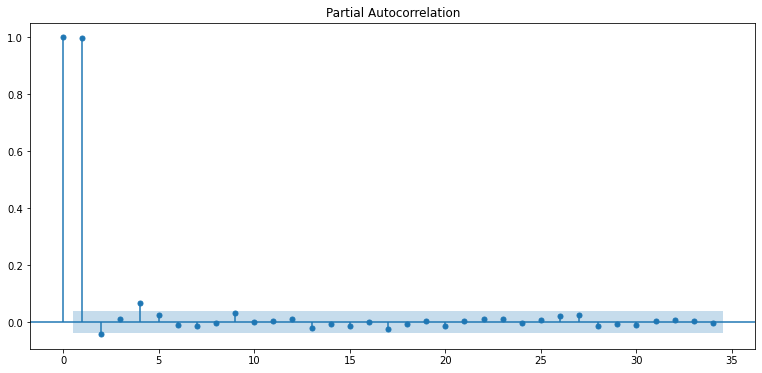

In [13]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

PACF 그래프를 볼 때 p=1이 매우 적합한 것 같다.  
p가 2 이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문이다.  
PACF가 0이라는 의미는 현재 데이터와 p 시점 떨어진 이전의 데이터는 상관도가 0  
즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻이다.

Results of Dickey-Fuller Test:
Test Statistic                  -26.974751
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    2459.000000
Critical Value (1%)              -3.433012
Critical Value (5%)              -2.862716
Critical Value (10%)             -2.567396
dtype: float64


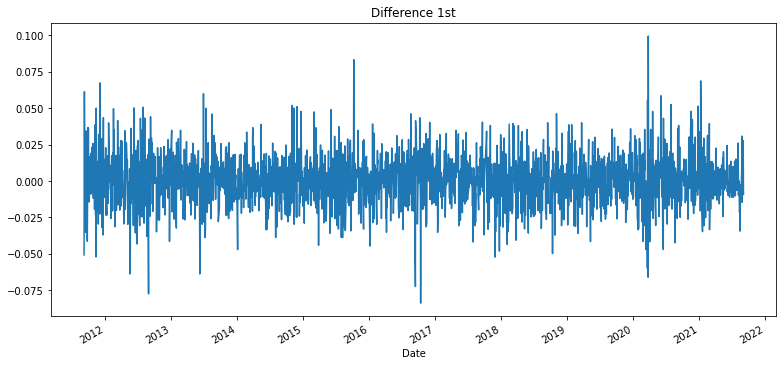

In [14]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.612675e+01
p-value                        4.832904e-29
#Lags Used                     2.700000e+01
Number of Observations Used    2.434000e+03
Critical Value (1%)           -3.433039e+00
Critical Value (5%)           -2.862728e+00
Critical Value (10%)          -2.567403e+00
dtype: float64


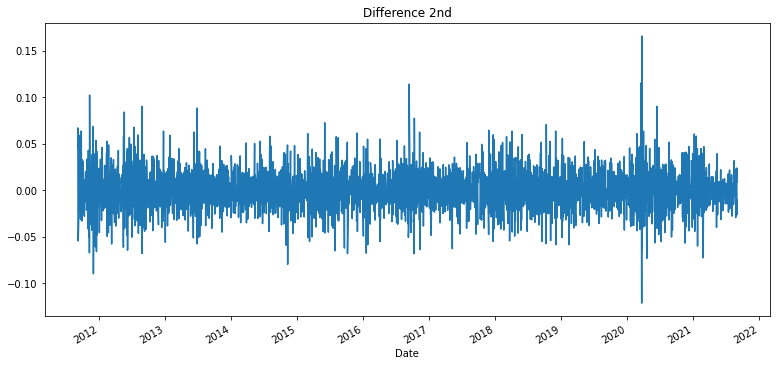

In [15]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## 6. ARIMA 모델 훈련과 테스트

In [16]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 2))  
fitted_m = model.fit(disp=-1)
print(fitted_m.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2216
Model:                 ARIMA(1, 1, 2)   Log Likelihood                5860.972
Method:                       css-mle   S.D. of innovations              0.017
Date:                Thu, 02 Sep 2021   AIC                         -11711.943
Time:                        03:13:26   BIC                         -11683.426
Sample:                             1   HQIC                        -11701.526
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0006      0.000      1.903      0.057   -1.76e-05       0.001
ar.L1.D.Close     0.6994      0.112      6.261      0.000       0.480       0.918
ma.L1.D.Close    -0.6872      0.112     

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


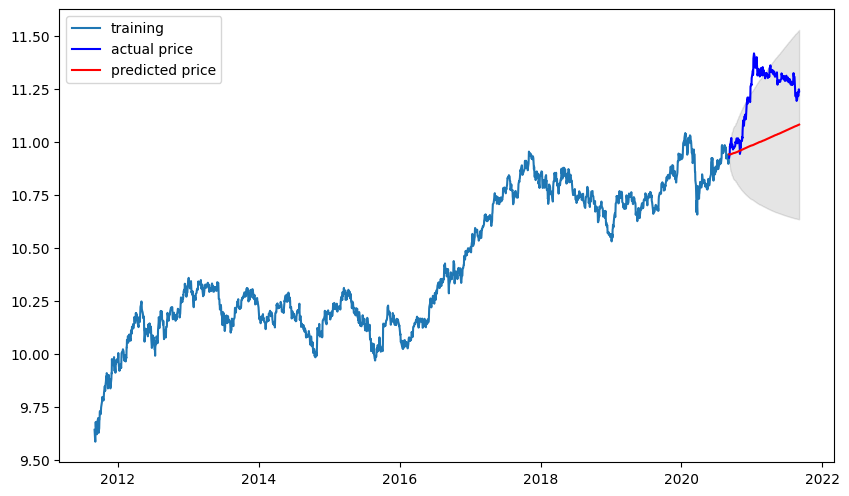

In [17]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,6), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  302696781.746531
MAE:  15486.153817376653
RMSE:  17398.183288680775
MAPE: 19.32%


MAPE가 약 19%의 정확도로 매우 좋지 않은 편이고  
실제로 그래프에서도 예측값이 실제와 차이가 많이난다.  

## 7. 다른 주식 종목 예측해 보기
예측 편의를 위해 함수 구현

In [19]:
def get_time_series_log(filename):
    # Time Series 생성
    dataset_dirpath = os.getenv('HOME') + '/aiffel/stock_prediction/datas'
    dataset_filepath = os.path.join(dataset_dirpath, filename)
    df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
    ts = df['Close']
    # 결측치 처리
    if len(ts[ts.isna()]) > 0:
        ts = ts.interpolate(method='time')
    # 로그 변환
    return np.log(ts)

In [20]:
def check_stationary(ts_log):
    # 정성적 그래프 분석
    plot_rolling_statistics(ts_log, window=12)
    # 정량적 Augmented Dicky-Fuller Test
    augmented_dickey_fuller_test(ts_log)

In [21]:
def time_series_decomposition(ts_log):
    # 시계열 분해 (Time Series Decomposition)
    decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.rcParams["figure.figsize"] = (12,6)
    plt.subplot(411)
    plt.plot(ts_log, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    
    # Residual 안정성 확인
    residual.dropna(inplace=True)
    augmented_dickey_fuller_test(residual)

In [22]:
def split_train_test_data(ts_log):
    train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.plot(ts_log, c='r', label='training dataset')  
    plt.plot(test_data, c='b', label='test dataset')
    plt.legend()
    return train_data, test_data

In [23]:
# ACF, PACF 그려보기 -> p,q 구하기
def plot_acf_pacf(ts_log):
    plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
    plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
    plt.show()

In [24]:
# 차분 안정성 확인 -> d 구하기
def get_difference(ts_log):
    # 1차 차분 구하기
    plt.subplot(211)
    diff_1 = ts_log.diff(periods=1).iloc[1:]
    diff_1.plot(title='Difference 1st')
    # 혹시 필요한 경우 2차 차분 구하기
    plt.subplot(212)
    diff_2 = diff_1.diff(periods=1).iloc[1:]
    diff_2.plot(title='Difference 2nd')

    print('Difference 1st:')
    augmented_dickey_fuller_test(diff_1)
    print('\nDifference 2nd:')
    augmented_dickey_fuller_test(diff_2)

In [25]:
def arima_train_test(order):
    # Build and Train  Model
    model = ARIMA(train_data, order=order)
    fitted_m = model.fit(disp=-1)
    print(fitted_m.summary())

    # Forecast : 결과가 fc에 담깁니다. 
    fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
    lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
    upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

    # Plot
    plt.figure(figsize=(10,6), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
    plt.legend()
    plt.show()

    # Score
    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)
    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)
    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)
    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))

### 7-1. 비트코인 예측

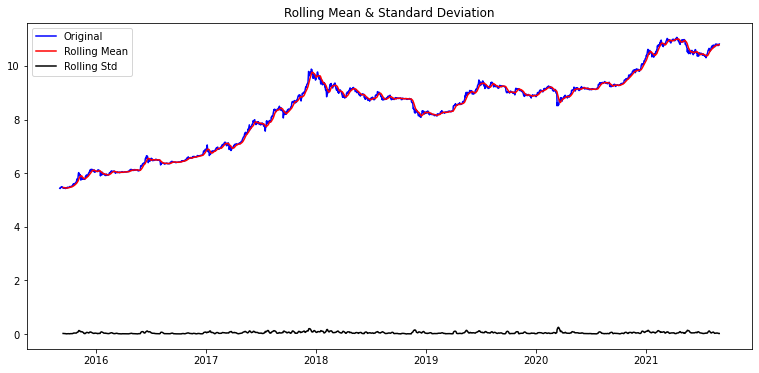

Results of Dickey-Fuller Test:
Test Statistic                   -1.129590
p-value                           0.703129
#Lags Used                        0.000000
Number of Observations Used    2192.000000
Critical Value (1%)              -3.433337
Critical Value (5%)              -2.862859
Critical Value (10%)             -2.567472
dtype: float64


In [26]:
# 데이터 불러와 Time Series 생성하기
ts_log = get_time_series_log('BTC-USD.csv')

# 정성적, 정량적 시계열 안정성 분석
check_stationary(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                -1.369087e+01
p-value                        1.344750e-25
#Lags Used                     2.000000e+01
Number of Observations Used    2.142000e+03
Critical Value (1%)           -3.433407e+00
Critical Value (5%)           -2.862890e+00
Critical Value (10%)          -2.567489e+00
dtype: float64


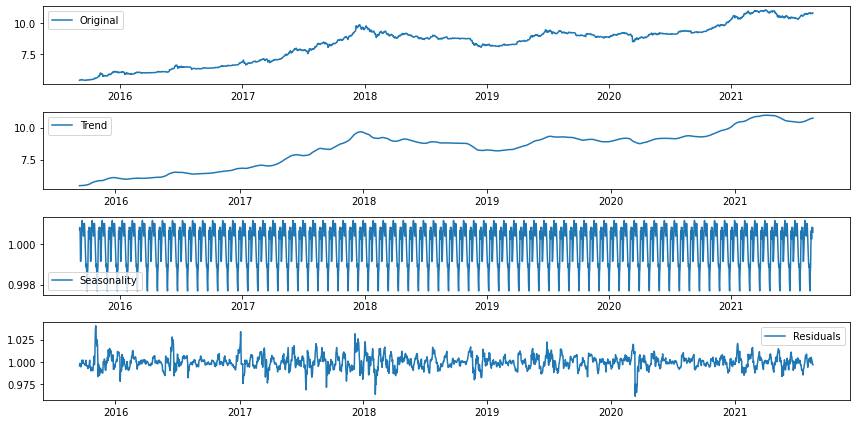

In [27]:
# 시계열 분해
time_series_decomposition(ts_log)

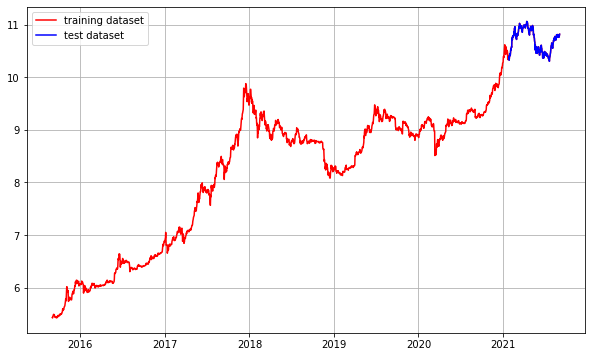

In [28]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = split_train_test_data(ts_log)

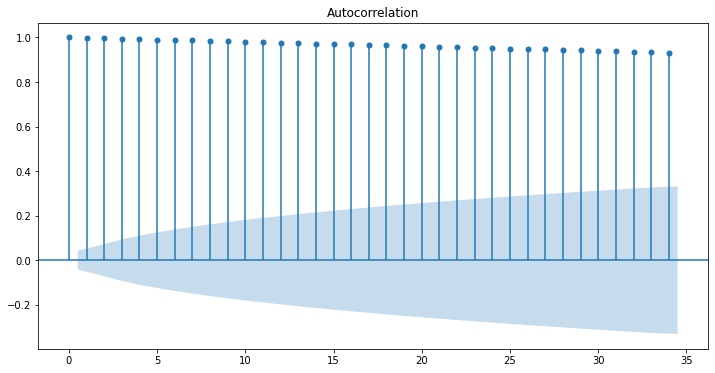

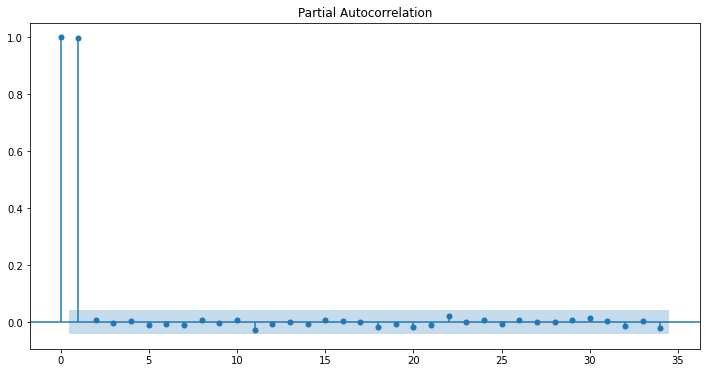

In [29]:
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf_pacf(ts_log)

Difference 1st:
Results of Dickey-Fuller Test:
Test Statistic                  -48.150291
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    2191.000000
Critical Value (1%)              -3.433338
Critical Value (5%)              -2.862860
Critical Value (10%)             -2.567473
dtype: float64

Difference 2nd:
Results of Dickey-Fuller Test:
Test Statistic                -1.483538e+01
p-value                        1.871874e-27
#Lags Used                     2.600000e+01
Number of Observations Used    2.164000e+03
Critical Value (1%)           -3.433375e+00
Critical Value (5%)           -2.862877e+00
Critical Value (10%)          -2.567482e+00
dtype: float64


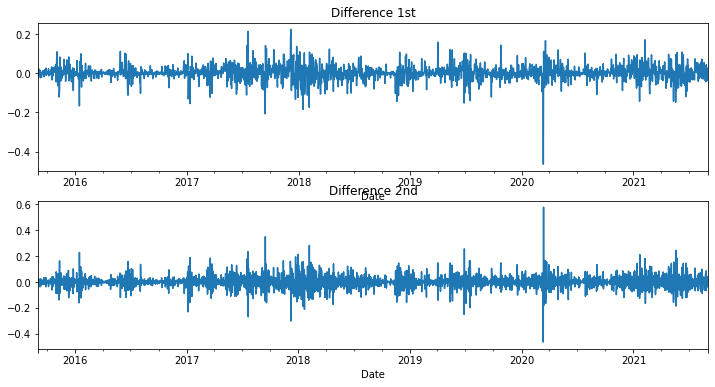

In [30]:
# 차분 안정성 확인 -> d 구하기
get_difference(ts_log)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be use

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                 1971
Model:                 ARIMA(1, 2, 2)   Log Likelihood                3578.595
Method:                       css-mle   S.D. of innovations              0.039
Date:                Thu, 02 Sep 2021   AIC                          -7147.191
Time:                        03:13:30   BIC                          -7119.259
Sample:                    09-04-2015   HQIC                         -7136.927
                         - 01-25-2021                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -6.311e-07   1.55e-06     -0.408      0.683   -3.66e-06     2.4e-06
ar.L1.D2.Close    -0.9167      0.051    -18.020      0.000      -1.016      -0.817
ma.L1.D2.Close    -0.0989      0.057

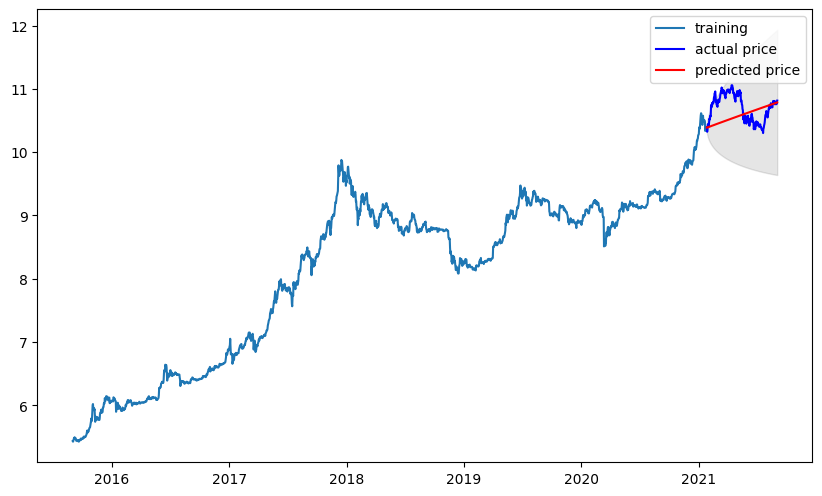

MSE:  174997774.2141983
MAE:  10906.27407257675
RMSE:  13228.672428259697
MAPE: 22.88%


In [31]:
# ARIMA 모델 훈련 및 테스트
arima_train_test((1, 2, 2))

비트코인은 변동이 너무 심해서 예측이 잘 안될 걸 알았지만  
궁금해서 한번 해보았다.

### 7-2. 애플 예측

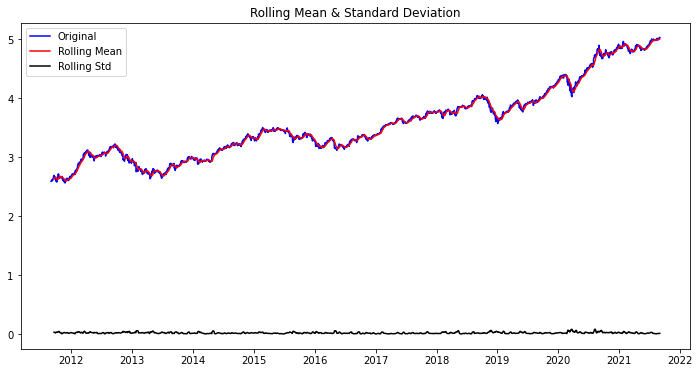

Results of Dickey-Fuller Test:
Test Statistic                    0.202307
p-value                           0.972391
#Lags Used                       22.000000
Number of Observations Used    2493.000000
Critical Value (1%)              -3.432976
Critical Value (5%)              -2.862700
Critical Value (10%)             -2.567388
dtype: float64


In [32]:
# 데이터 불러와 Time Series 생성하기
ts_log = get_time_series_log('AAPL.csv')

# 정성적, 정량적 시계열 안정성 분석
check_stationary(ts_log)

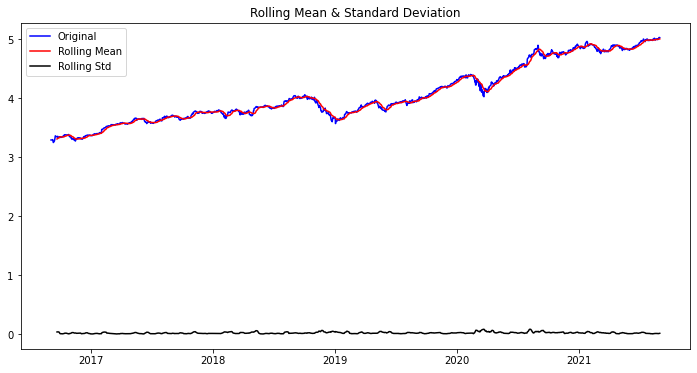

Results of Dickey-Fuller Test:
Test Statistic                    0.000847
p-value                           0.958602
#Lags Used                        9.000000
Number of Observations Used    1248.000000
Critical Value (1%)              -3.435601
Critical Value (5%)              -2.863859
Critical Value (10%)             -2.568004
dtype: float64


In [33]:
# 기간 조정
ts_log = ts_log['2016-09-02':]
check_stationary(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                -9.596755e+00
p-value                        1.968959e-16
#Lags Used                     2.100000e+01
Number of Observations Used    1.206000e+03
Critical Value (1%)           -3.435784e+00
Critical Value (5%)           -2.863940e+00
Critical Value (10%)          -2.568048e+00
dtype: float64


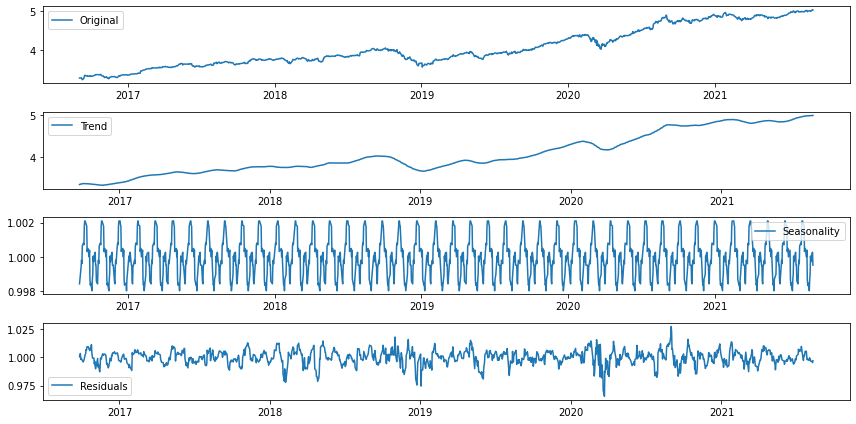

In [34]:
# 시계열 분해
time_series_decomposition(ts_log)

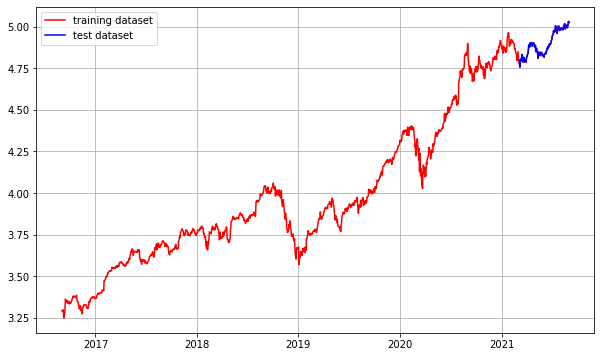

In [35]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = split_train_test_data(ts_log)

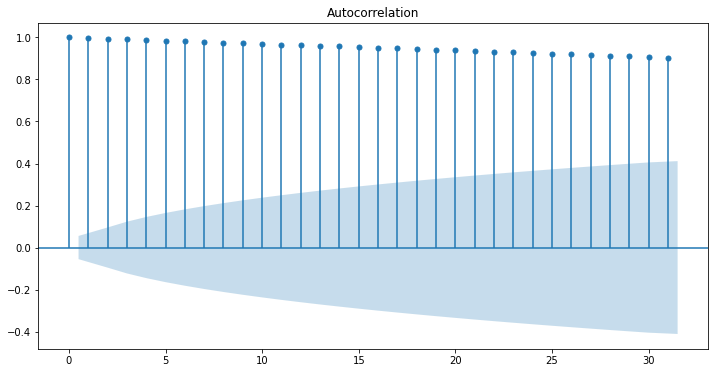

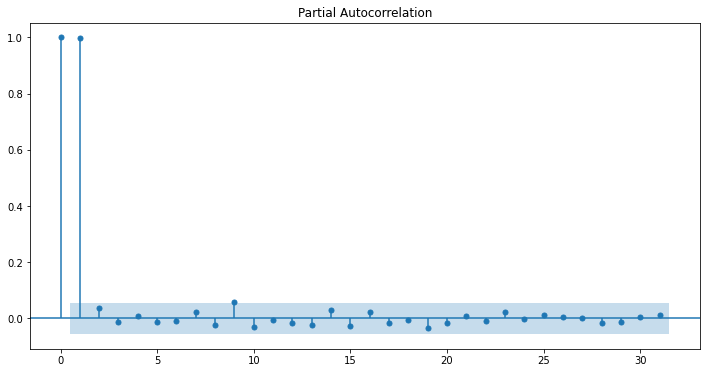

In [36]:
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf_pacf(ts_log)

Difference 1st:
Results of Dickey-Fuller Test:
Test Statistic                -1.103363e+01
p-value                        5.587382e-20
#Lags Used                     8.000000e+00
Number of Observations Used    1.248000e+03
Critical Value (1%)           -3.435601e+00
Critical Value (5%)           -2.863859e+00
Critical Value (10%)          -2.568004e+00
dtype: float64

Difference 2nd:
Results of Dickey-Fuller Test:
Test Statistic                -1.557313e+01
p-value                        1.975161e-28
#Lags Used                     1.700000e+01
Number of Observations Used    1.238000e+03
Critical Value (1%)           -3.435643e+00
Critical Value (5%)           -2.863877e+00
Critical Value (10%)          -2.568014e+00
dtype: float64


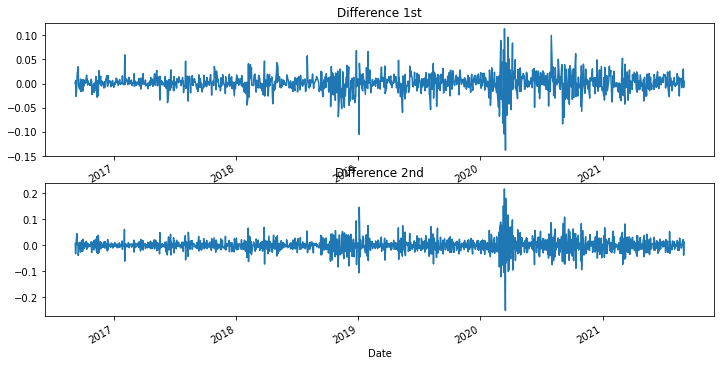

In [37]:
# 차분 안정성 확인 -> d 구하기
get_difference(ts_log)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1131
Model:                 ARIMA(3, 1, 1)   Log Likelihood                2855.117
Method:                       css-mle   S.D. of innovations              0.019
Date:                Thu, 02 Sep 2021   AIC                          -5698.233
Time:                        03:13:33   BIC                          -5668.048
Sample:                             1   HQIC                         -5686.830
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0013      0.001      2.562      0.010       0.000       0.002
ar.L1.D.Close     0.0562      1.509      0.037      0.970      -2.901       3.013
ar.L2.D.Close     0.0372      0.187     

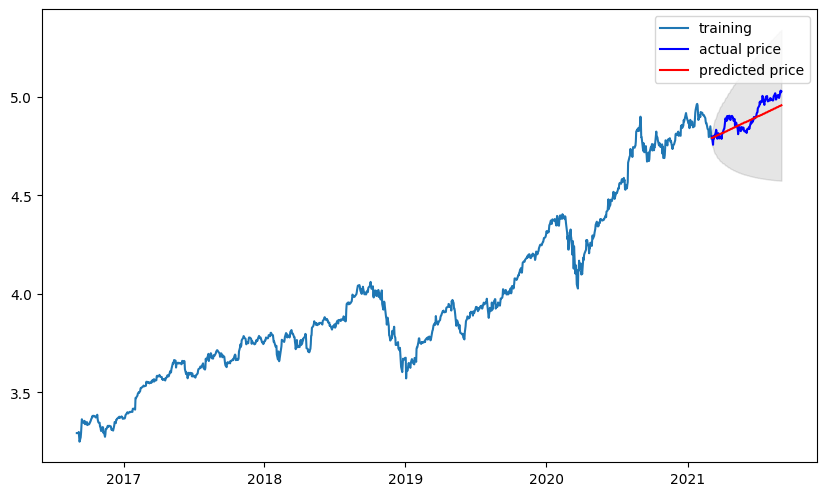

MSE:  40.738356833603774
MAE:  5.396952944036922
RMSE:  6.3826606390755085
MAPE: 3.90%


In [38]:
# ARIMA 모델 훈련 및 테스트
arima_train_test((3, 1, 1))

애플의 경우는 예측하기 좋게 꾸준한 우상향을 하므로 MAPE값이 3.90%로 잘 나온 것 같다.

### 7-3. GE 예측

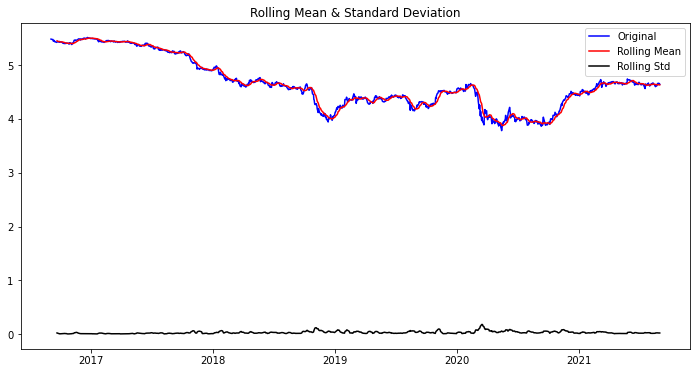

Results of Dickey-Fuller Test:
Test Statistic                   -1.762100
p-value                           0.399434
#Lags Used                       12.000000
Number of Observations Used    1245.000000
Critical Value (1%)              -3.435613
Critical Value (5%)              -2.863864
Critical Value (10%)             -2.568007
dtype: float64


In [39]:
# 데이터 불러와 Time Series 생성하기
ts_log = get_time_series_log('GE.csv')

# 정성적, 정량적 시계열 안정성 분석
check_stationary(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                -1.036380e+01
p-value                        2.358825e-18
#Lags Used                     1.800000e+01
Number of Observations Used    1.209000e+03
Critical Value (1%)           -3.435770e+00
Critical Value (5%)           -2.863934e+00
Critical Value (10%)          -2.568044e+00
dtype: float64


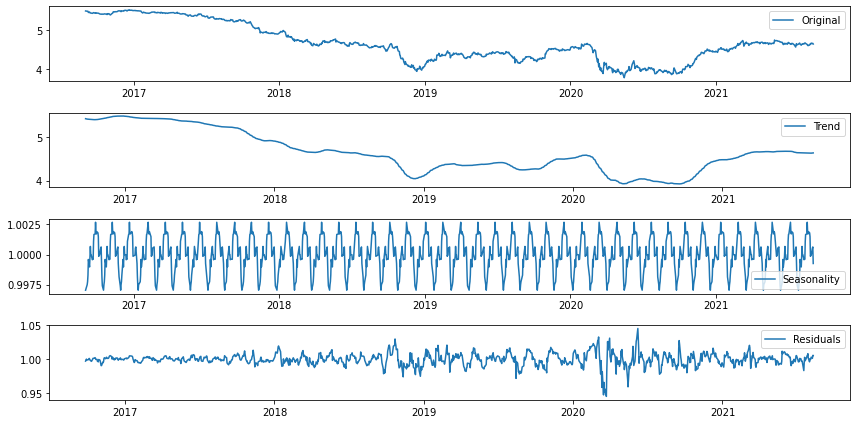

In [40]:
# 시계열 분해
time_series_decomposition(ts_log)

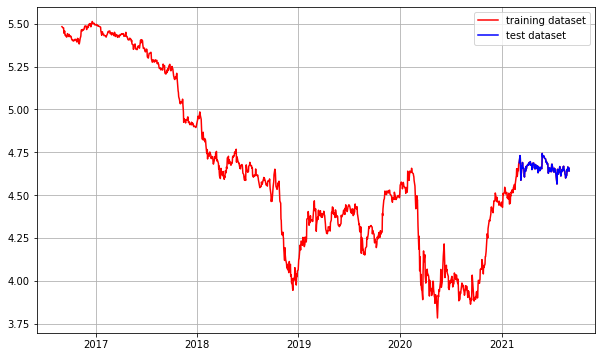

In [41]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = split_train_test_data(ts_log)

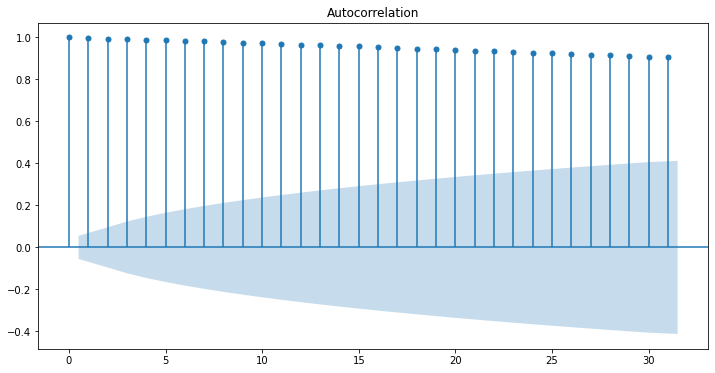

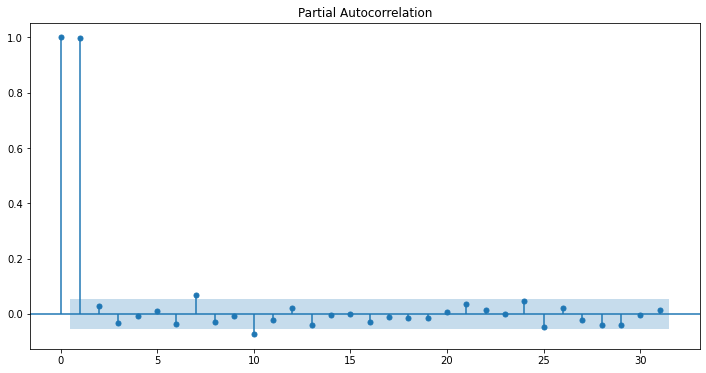

In [42]:
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf_pacf(ts_log)

Difference 1st:
Results of Dickey-Fuller Test:
Test Statistic                -8.996681e+00
p-value                        6.665545e-15
#Lags Used                     1.100000e+01
Number of Observations Used    1.245000e+03
Critical Value (1%)           -3.435613e+00
Critical Value (5%)           -2.863864e+00
Critical Value (10%)          -2.568007e+00
dtype: float64

Difference 2nd:
Results of Dickey-Fuller Test:
Test Statistic                -1.185016e+01
p-value                        7.240151e-22
#Lags Used                     2.200000e+01
Number of Observations Used    1.233000e+03
Critical Value (1%)           -3.435665e+00
Critical Value (5%)           -2.863887e+00
Critical Value (10%)          -2.568020e+00
dtype: float64


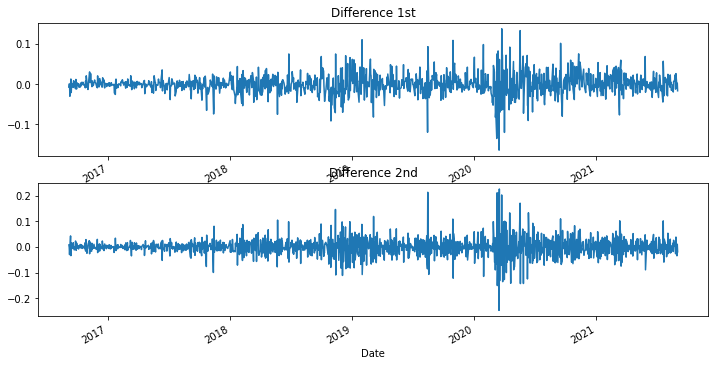

In [43]:
# 차분 안정성 확인 -> d 구하기
get_difference(ts_log)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1131
Model:                 ARIMA(3, 1, 1)   Log Likelihood                2503.871
Method:                       css-mle   S.D. of innovations              0.026
Date:                Thu, 02 Sep 2021   AIC                          -4995.743
Time:                        03:13:36   BIC                          -4965.557
Sample:                             1   HQIC                         -4984.339
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0007      0.001     -0.674      0.500      -0.003       0.001
ar.L1.D.Close     0.8752      0.077     11.321      0.000       0.724       1.027
ar.L2.D.Close     0.0898      0.039     

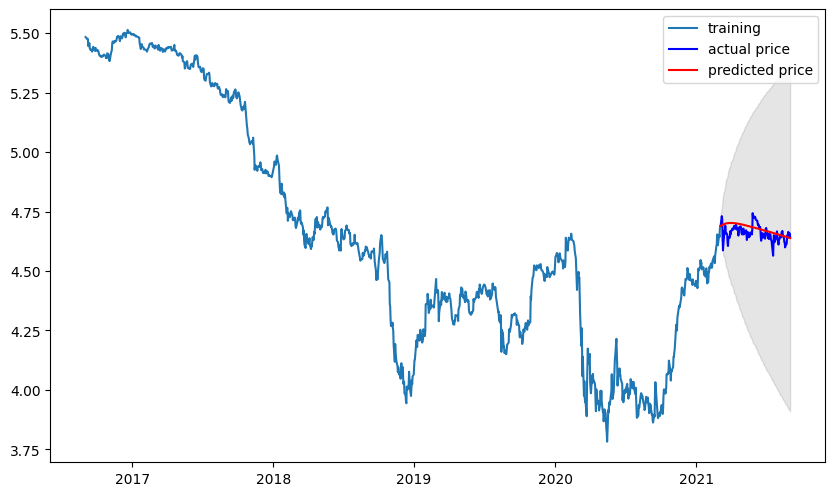

MSE:  13.600993944773473
MAE:  3.0405100685492417
RMSE:  3.6879525410142513
MAPE: 2.90%


In [44]:
# ARIMA 모델 훈련 및 테스트
arima_train_test((3, 1, 1))

GE의 경우는 거의 완벽한 예측을 볼 수 있다.

### 7-4. 네이버 예측

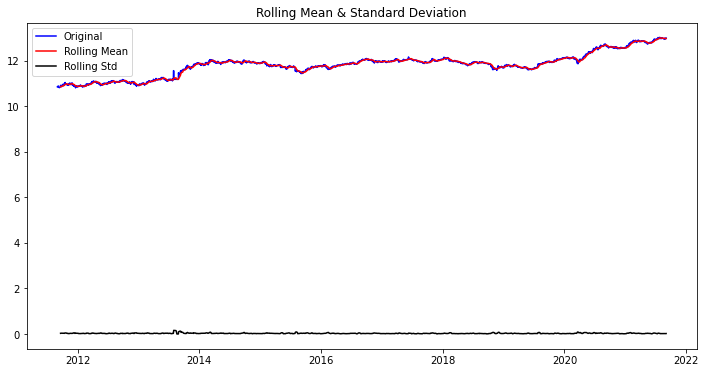

Results of Dickey-Fuller Test:
Test Statistic                   -0.463097
p-value                           0.899019
#Lags Used                        4.000000
Number of Observations Used    2459.000000
Critical Value (1%)              -3.433012
Critical Value (5%)              -2.862716
Critical Value (10%)             -2.567396
dtype: float64


In [45]:
# 데이터 불러와 Time Series 생성하기
ts_log = get_time_series_log('035420.KS.csv')

# 정성적, 정량적 시계열 안정성 분석
check_stationary(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                -1.336077e+01
p-value                        5.433784e-25
#Lags Used                     2.500000e+01
Number of Observations Used    2.408000e+03
Critical Value (1%)           -3.433069e+00
Critical Value (5%)           -2.862741e+00
Critical Value (10%)          -2.567409e+00
dtype: float64


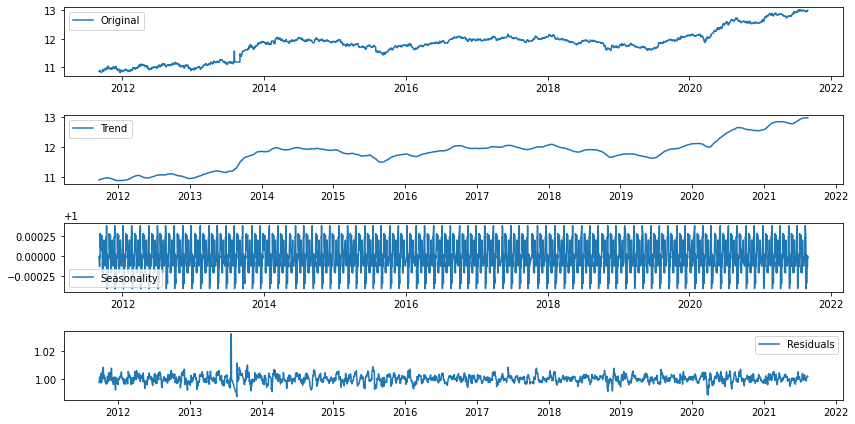

In [46]:
# 시계열 분해
time_series_decomposition(ts_log)

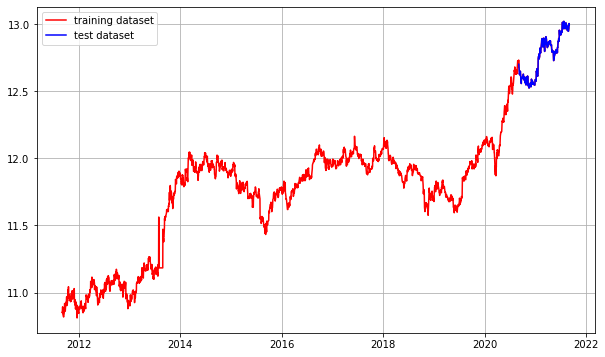

In [47]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = split_train_test_data(ts_log)

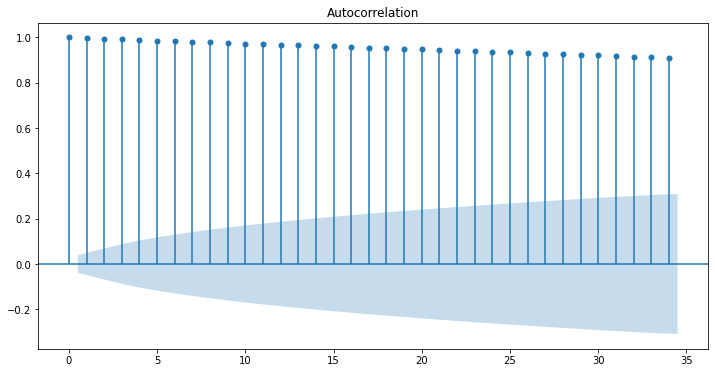

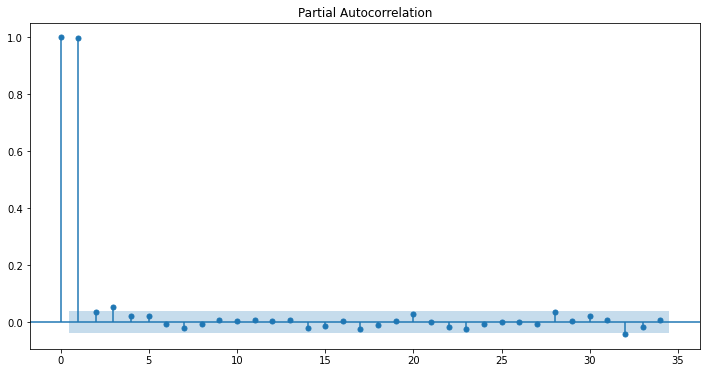

In [48]:
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf_pacf(ts_log)

Difference 1st:
Results of Dickey-Fuller Test:
Test Statistic                  -28.793811
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    2459.000000
Critical Value (1%)              -3.433012
Critical Value (5%)              -2.862716
Critical Value (10%)             -2.567396
dtype: float64

Difference 2nd:
Results of Dickey-Fuller Test:
Test Statistic                -1.828193e+01
p-value                        2.307321e-30
#Lags Used                     2.300000e+01
Number of Observations Used    2.438000e+03
Critical Value (1%)           -3.433035e+00
Critical Value (5%)           -2.862726e+00
Critical Value (10%)          -2.567401e+00
dtype: float64


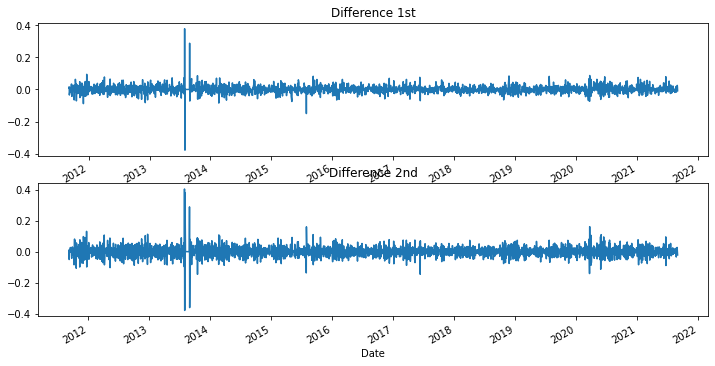

In [49]:
# 차분 안정성 확인 -> d 구하기
get_difference(ts_log)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2216
Model:                 ARIMA(3, 1, 1)   Log Likelihood                4985.270
Method:                       css-mle   S.D. of innovations              0.026
Date:                Thu, 02 Sep 2021   AIC                          -9958.540
Time:                        03:13:39   BIC                          -9924.319
Sample:                             1   HQIC                         -9946.040
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.000      2.085      0.037    5.07e-05       0.002
ar.L1.D.Close     0.5253      0.168      3.128      0.002       0.196       0.854
ar.L2.D.Close    -0.0438      0.029     

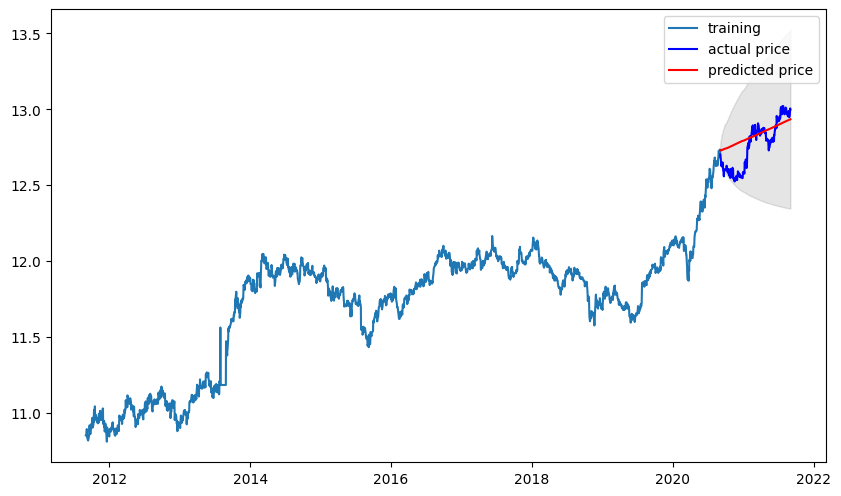

MSE:  1636522535.372055
MAE:  33417.40935423377
RMSE:  40453.95574442696
MAPE: 10.42%


In [50]:
# ARIMA 모델 훈련 및 테스트
arima_train_test((3, 1, 1))

### 7-5. 카카오 예측

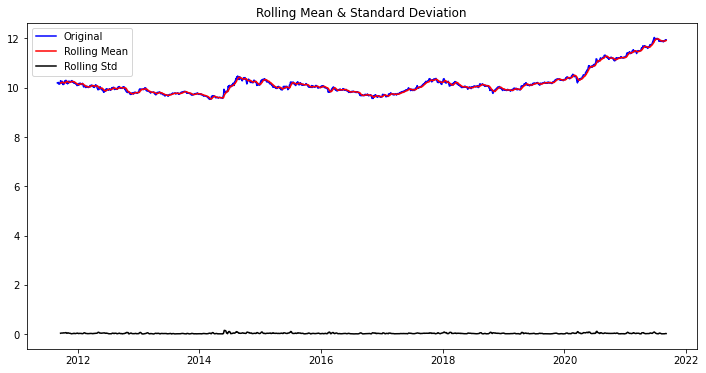

Results of Dickey-Fuller Test:
Test Statistic                    1.416607
p-value                           0.997188
#Lags Used                        6.000000
Number of Observations Used    2457.000000
Critical Value (1%)              -3.433014
Critical Value (5%)              -2.862717
Critical Value (10%)             -2.567397
dtype: float64


In [51]:
# 데이터 불러와 Time Series 생성하기
ts_log = get_time_series_log('035720.KS.csv')

# 정성적, 정량적 시계열 안정성 분석
check_stationary(ts_log)

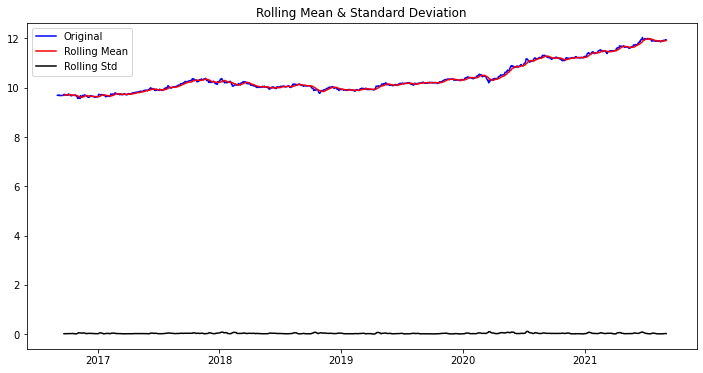

Results of Dickey-Fuller Test:
Test Statistic                    0.983369
p-value                           0.994087
#Lags Used                        2.000000
Number of Observations Used    1225.000000
Critical Value (1%)              -3.435699
Critical Value (5%)              -2.863902
Critical Value (10%)             -2.568028
dtype: float64


In [52]:
# 기간 조정
ts_log = ts_log['2016-09-02':]
check_stationary(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                -1.058765e+01
p-value                        6.652576e-19
#Lags Used                     2.300000e+01
Number of Observations Used    1.174000e+03
Critical Value (1%)           -3.435932e+00
Critical Value (5%)           -2.864005e+00
Critical Value (10%)          -2.568082e+00
dtype: float64


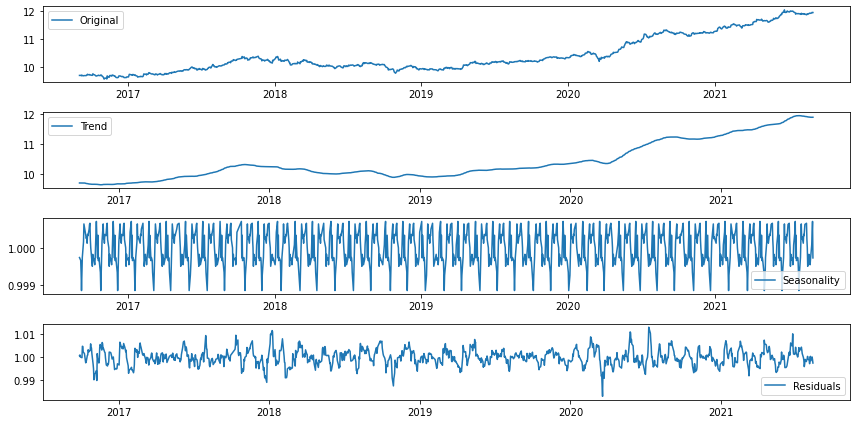

In [53]:
# 시계열 분해
time_series_decomposition(ts_log)

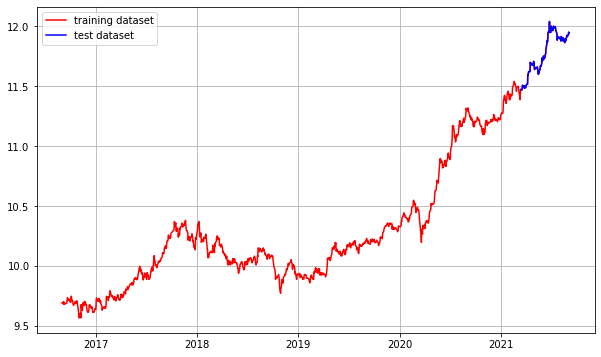

In [54]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = split_train_test_data(ts_log)

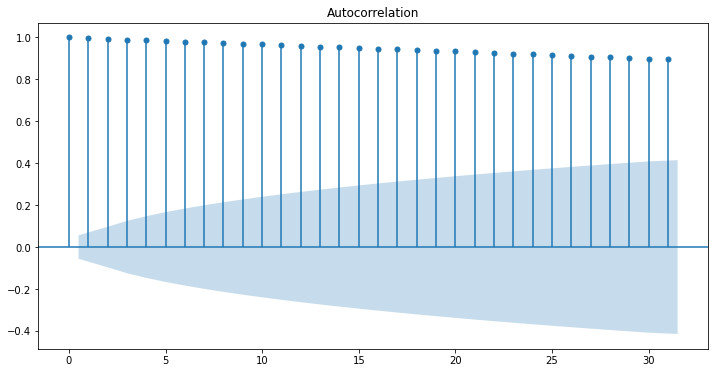

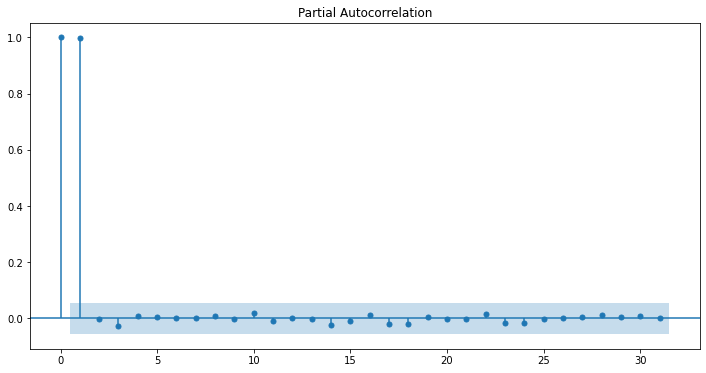

In [55]:
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf_pacf(ts_log)

Difference 1st:
Results of Dickey-Fuller Test:
Test Statistic                  -22.780800
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    1225.000000
Critical Value (1%)              -3.435699
Critical Value (5%)              -2.863902
Critical Value (10%)             -2.568028
dtype: float64

Difference 2nd:
Results of Dickey-Fuller Test:
Test Statistic                -1.283623e+01
p-value                        5.732911e-24
#Lags Used                     2.100000e+01
Number of Observations Used    1.204000e+03
Critical Value (1%)           -3.435793e+00
Critical Value (5%)           -2.863944e+00
Critical Value (10%)          -2.568050e+00
dtype: float64


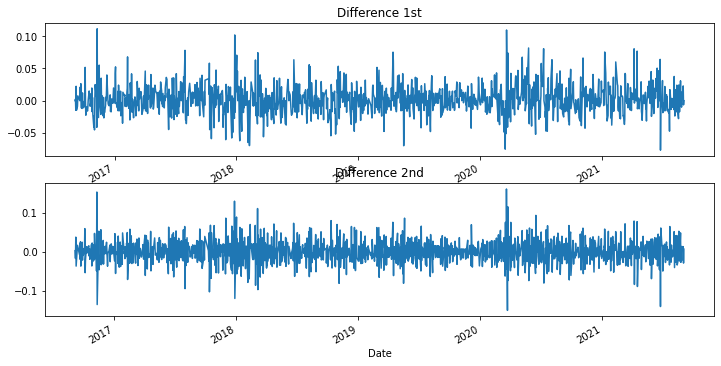

In [56]:
# 차분 안정성 확인 -> d 구하기
get_difference(ts_log)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                 1103
Model:                 ARIMA(1, 2, 3)   Log Likelihood                2620.098
Method:                       css-mle   S.D. of innovations              0.022
Date:                Thu, 02 Sep 2021   AIC                          -5228.196
Time:                        03:13:43   BIC                          -5198.162
Sample:                             2   HQIC                         -5216.835
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.792e-06   3.26e-06      0.857      0.392    -3.6e-06    9.18e-06
ar.L1.D2.Close    -0.7216      0.176     -4.090      0.000      -1.067      -0.376
ma.L1.D2.Close    -0.2780      0.180

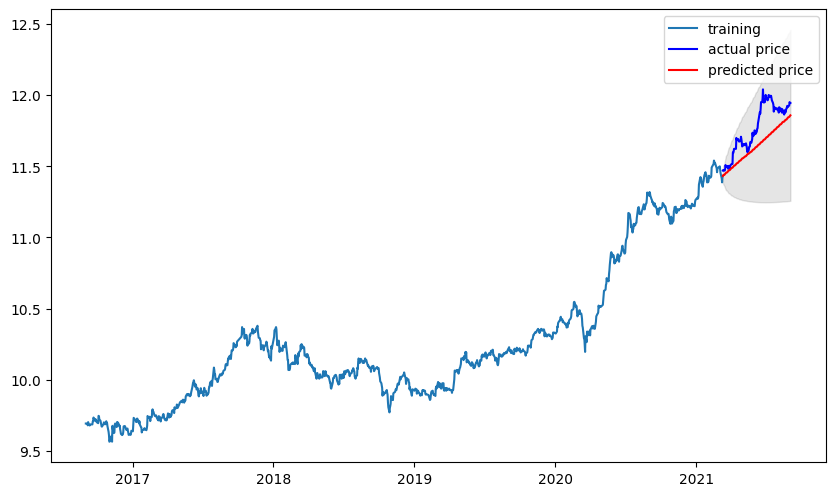

MSE:  408988662.2051932
MAE:  16461.819410649587
RMSE:  20223.46810527792
MAPE: 11.70%


In [57]:
# ARIMA 모델 훈련 및 테스트
arima_train_test((1, 2, 3))

# 프로젝트 결과
- 처음에 SK 하이닉스 같은 국내 기업 데이터셋으로 예측해보았는데 국내 기업들은 코로나를 기점으로 변동성이 너무 심해서 그런지 MAPE 값이 좋지가 않았다. 카카오나 네이버는 그래도 변동성이 덜한편이라 MAPE 값이 좋게 나온걸 볼 수 있다.
- 변동이 심해 예측하기 좋지 않았던 그래프들은 arima의 order 파라미터를 아무리 조정해도 예측 개선에 한계가 있었는데 데이터셋의 기간을 조정해보니 눈에 띄게 예측이 좋아진걸 볼 수 있었다. (물론 이건 지금 시점에서의 프로젝트를 위한 편법일지도 모른다.) 결국 데이터가 많다고해서 예측이 잘 되는 것도 아니고 알아서 주가가 안정적인 구간을 탐색해주는 알고리즘이 개발된다면 주가 예측 프로그램의 정확도가 매우 높아질 것이라는 생각이 든다.(이미 적용되고 있는지도 모른다.)
- 주가를 예측하는 프로그램은 말로만 들었지 실제로 해보니 너무 신기하고 이런걸 해주는 프로그램이 있는 걸로 알고 있는데 이제 AI가 적용된 주식장은 개미가 프로그램없이 이겨낼 수 있을지 의문이다. 근데 사실 주가는 신도 모르는 거기 때문에 프로그램이 의미가 많이 있을지도 의문이다. 돈이 걸린 문제이니만큼 절대 프로그램에만 의존해서는 안될 것이다. 

## MAPE 값 개선 꿀팁
- arima의 order 파라미터를 수정하기(ARIMA의 모수 p, d, q)
- 예측에 사용할 데이터셋의 기간을 조정해보기(이게 가장 베스트)